<a href="https://colab.research.google.com/github/jeawonlll/KOHI2022_tutorials/blob/main/20220903/%5Bpublic%5D_10_svpred_model_training_and_visualize_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료인공지능 전문가 양성과정 2022
## VitalDB Hands-on <br> Stroke volume prediction using arterial wave - model building
- Date : Sep. 03, 2022
- Author : **Hyun-Lim Yang, Ph.D.**<br>
Research Assistant Professor @
Seoul National University Hospital <br>
Department of Anesthesiology and Pain Medicine
- E-mail : hlyang{_at_}snu{_dot_}ac{_dot_}kr
***

In [ ]:
from IPython.display import HTML
style_warn = "<style>div.warn { background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
HTML(style_warn)

### Import packages

<div class="warn">**Warning!** : use your directory at `download_directory`</div>


> **Wargning** <br>
> colab 환경을 위한 google drive import 코드가 포함되어 있습니다. <br>
> 로컬 환경에서 실행 시 colab을 위한 import function들을 comment out 한 뒤 실행하세요. 

In [ ]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab

In [ ]:
import os
cloud_directory = '/content/gdrive/My Drive/KOHI_2022_CNN_data_open/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

In [ ]:
import sys
#download_directory = os.getcwd() # for local environments
#sys.path.append(download_directory) # for local environments
sys.path.append(cloud_directory) # for colab

In [ ]:
import numpy as np
import pandas as pd
import keras
import glob
import kohi_preprocessor as pre
from tqdm import tqdm
import warnings
import pickle
warnings.filterwarnings(action='ignore')

download_directory = cloud_directory # for colab

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.cm as cm

### Data loading
사전에 구축된 데이터셋 로드

In [ ]:
with open('{}/datasets/svpred_alines_20sec.np'.format(download_directory), 'rb') as f:
    aline_data = pickle.load(f)
    
with open('{}/datasets/svpred_ylabels_20sec.np'.format(download_directory), 'rb') as f:
    ylabel_data = pickle.load(f)
    
with open('{}/datasets/svpred_charts_20sec.np'.format(download_directory), 'rb') as f:
    charts_data = pickle.load(f)
    

### Train data와 Valid 데이터로 데이터 구분
편의를 위해 여기선 **180번** 차트 이후의 데이터를 모두 testset으로 구분

In [ ]:

### =========== Your code here ====================

test_index = (charts_data > '00180')
train_index = ~test_index

aline_train = aline_data[train_index]
ylabel_train = ylabel_data[train_index]
charts_train = charts_data[train_index]

aline_test = aline_data[test_index]
ylabel_test = ylabel_data[test_index]
charts_test = charts_data[test_index]

### ===============================================


### Model building에 필요한 패키지 불러오기

In [ ]:
import tensorflow as tf
#import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, concatenate, multiply, dot
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Add, ReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

### CNN 모델 정의
실습에 사용될 CNN 구조

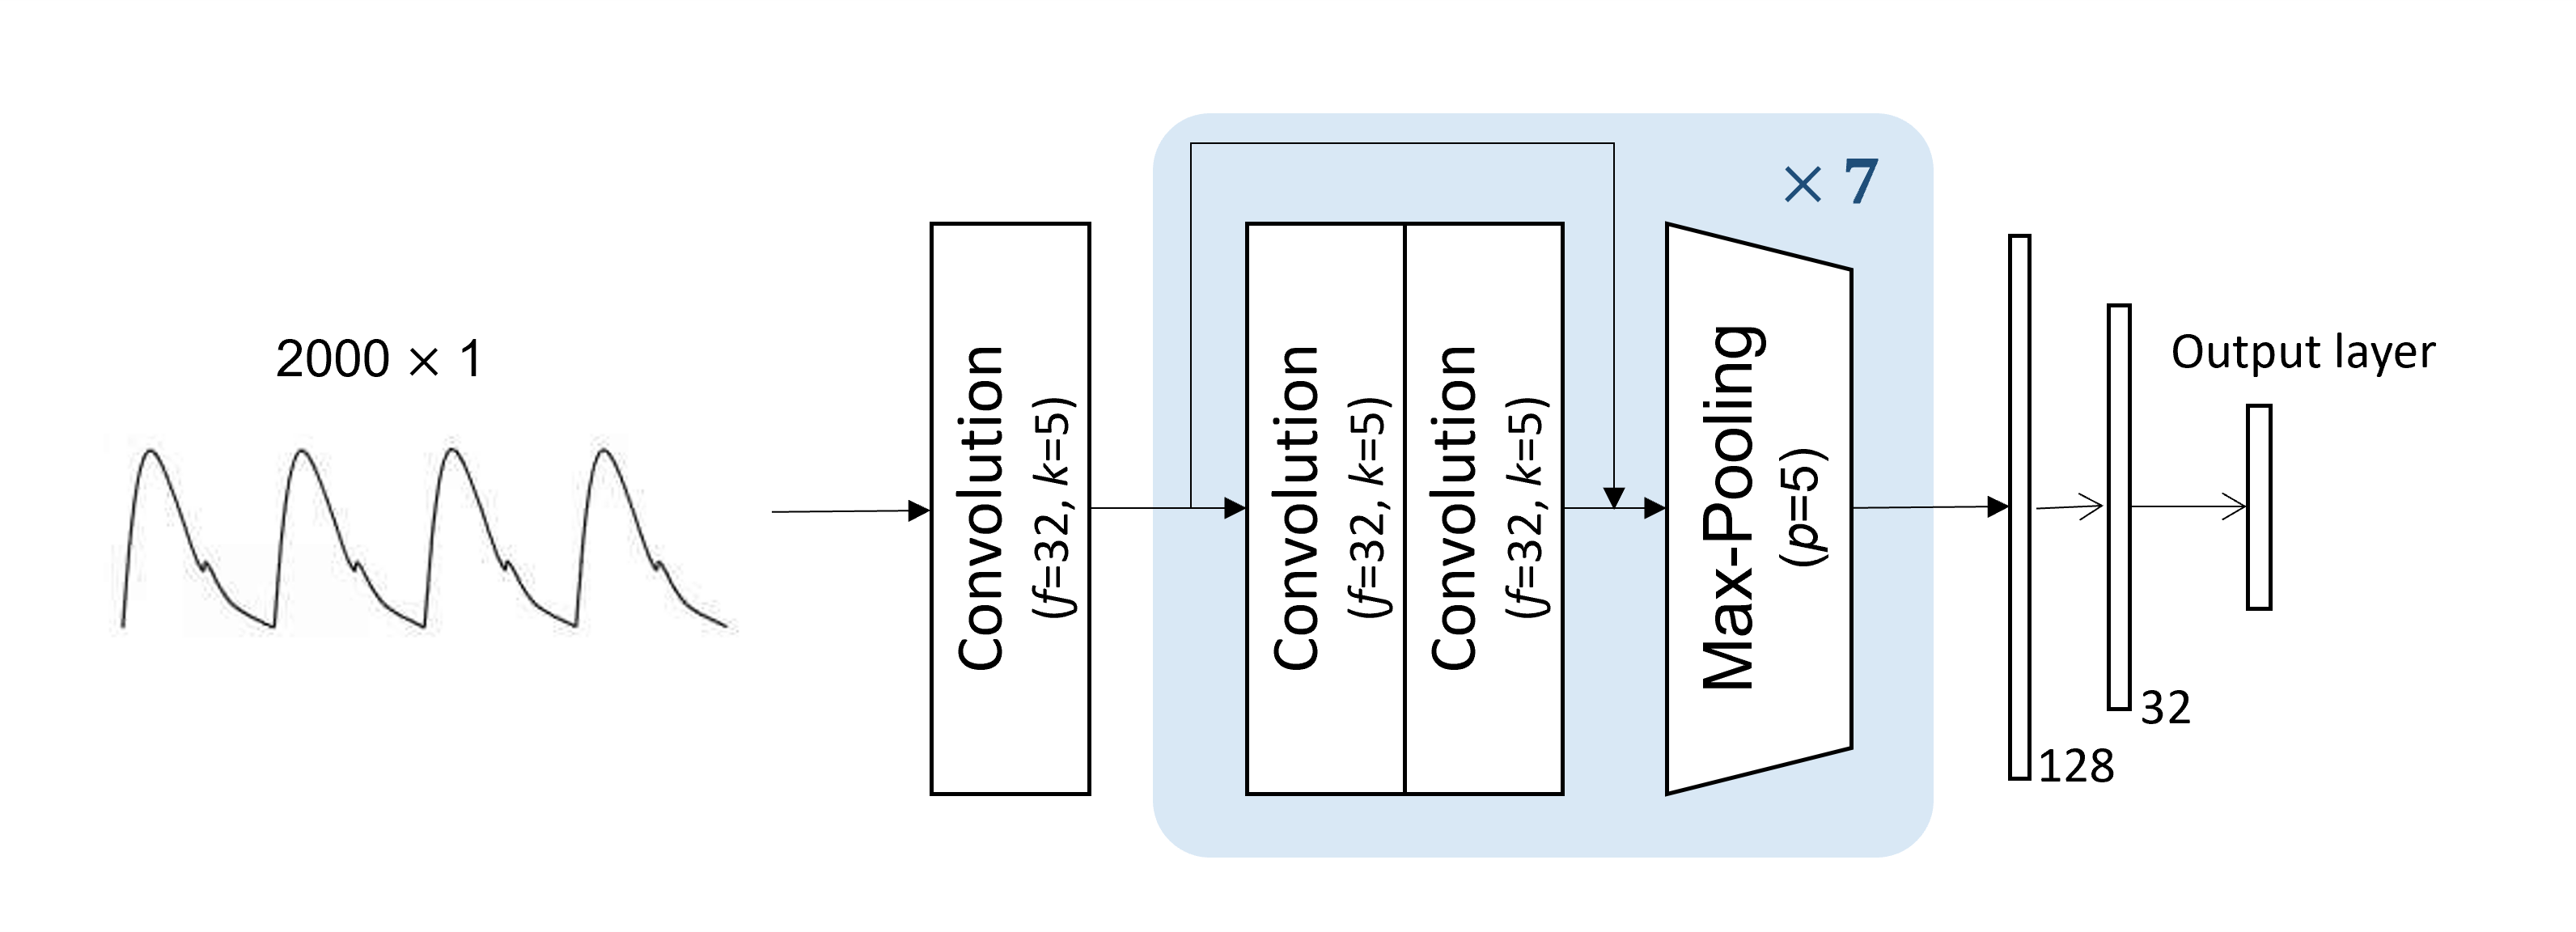

In [ ]:
from IPython.display import Image
Image(filename="{}/kohi_CNN_model_archi.png".format(download_directory))

Keras를 이용한 CNN 구현 코드 (Regression problem)

In [ ]:
batch_size = 2000

inp = Input(shape=(aline_train.shape[1], 1))

#stem
x = Conv1D(filters=32, kernel_size=5, activation='relu')(inp)

# block 1
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(x)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([x, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 2
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 3
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 4
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 5
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 6
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 7
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# regression을 수행할 수 있는 MLP layer 정의
# Two dense layer with 128 and 32 nodes
### =========== Your code here ====================

# MLP Layers
out = Flatten()(out)
out = Dense(128, activation='relu')(out)
out = Dense(32, activation='relu')(out)
out = Dense(1)(out)

### ===============================================

2022-09-02 20:06:52.086757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-02 20:06:53.379755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0


simple cnn model compile <br>
loss는 `mse` (mean squred error) 를 사용, metric은 `mae` (mean absolute error) 와 `mse` (mean squred error)를 사용 

In [ ]:
# 모델의 input과 output pipeline 정의
# 모델 컴파일 
### =========== Your code here ====================

simple_cnn_model = Model(inputs=[inp], outputs=[out])
adam_optimizer = optimizers.Adam(lr=0.0001)
simple_cnn_model.compile(loss='mse', optimizer=adam_optimizer, metrics=['mae', 'mse'])

### ===============================================

In [ ]:
simple_cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1996, 32)     192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1996, 32)     5152        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1996, 32)     5152        ['conv1d_1[0][0]']               
                                                                                              

### 모델 학습 파라미터 정의 및 학습 수행
`cache_path`: 모델이 저장될 경로 지정 <br>
`callback_functions`: 모델 학습에 사용되는 파라미터 설정 <br>

In [ ]:
cache_path = os.path.join("/content/gdrive/My Drive/", "simple_cnn_weight_sv.h5") # for colab
# cache_path = os.path.join(download_directory, "simple_cnn_weight_sv.h5") # for local
callback_functions = [ModelCheckpoint(monitor='val_loss', filepath=cache_path, verbose=1, save_best_only=True),
                      EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
                      ]

In [ ]:
# 모델 학습 수행
### =========== Your code here ====================

simple_cnn_train_history = simple_cnn_model.fit(aline_train, ylabel_train, epochs = 10, 
                                                batch_size=batch_size, verbose=1, validation_split=0.2,
                                               callbacks=callback_functions)

### ===============================================

Epoch 1/10


2022-09-02 20:06:58.276914: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-09-02 20:06:59.140547: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


41/41 [==============================] - ETA: 0s - loss: 668.2865 - mae: 20.5900 - mse: 668.2865
Epoch 1: val_loss improved from inf to 767.02167, saving model to /home/lims1/python/KOHIadvance2022/simple_cnn_weight_sv.h5
41/41 [==============================] - 14s 206ms/step - loss: 668.2865 - mae: 20.5900 - mse: 668.2865 - val_loss: 767.0217 - val_mae: 22.8993 - val_mse: 767.0217
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 545.9654 - mae: 18.7692 - mse: 545.9654
Epoch 2: val_loss improved from 767.02167 to 764.00610, saving model to /home/lims1/python/KOHIadvance2022/simple_cnn_weight_sv.h5
41/41 [==============================] - 7s 170ms/step - loss: 545.9654 - mae: 18.7692 - mse: 545.9654 - val_loss: 764.0061 - val_mae: 22.8265 - val_mse: 764.0061
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 502.7605 - mae: 17.9148 - mse: 502.7605
Epoch 3: val_loss improved from 764.00610 to 621.88464, saving model to /home/lims1/python/KOHIadvance20

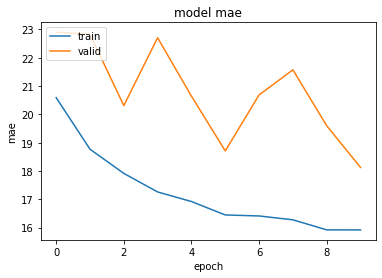

In [ ]:
# 모델의 mae loss plotting
### =========== Your code here ====================

plt.plot(simple_cnn_train_history.history['mae'])
plt.plot(simple_cnn_train_history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### ===============================================

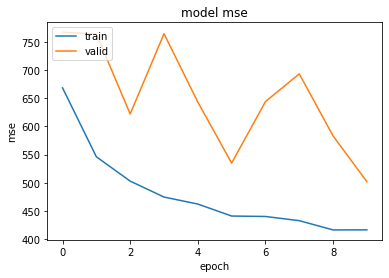

In [ ]:
# 모델의 mse loss plotting
### =========== Your code here ====================

plt.plot(simple_cnn_train_history.history['mse'])
plt.plot(simple_cnn_train_history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### ===============================================

In [ ]:
simple_cnn_model.load_weights(cache_path)
simple_cnn_result = simple_cnn_model.predict(aline_test).flatten()

267/267 [==============================] - 2s 6ms/step


In [ ]:
simple_cnn_result

array([61.998425, 64.29671 , 64.804955, ..., 70.34056 , 69.20739 ,
       74.040184], dtype=float32)

In [ ]:
ylabel_test

array([60., 59., 60., ..., 81., 79., 80.])

### 학습된 모델 Visialization
> 주황색이 우리 모델의 예측값이고, 파란색의 정답 입니다.

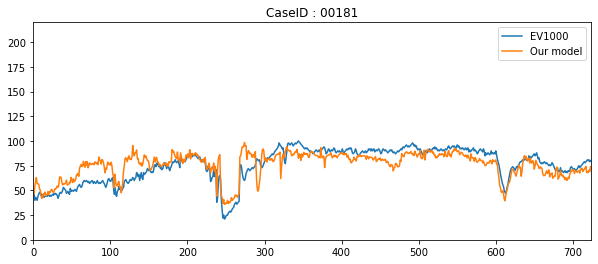

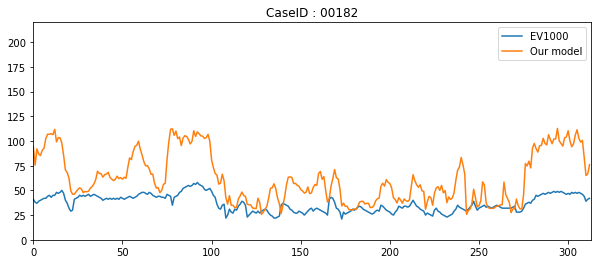

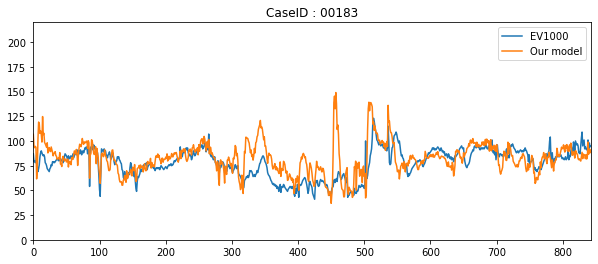

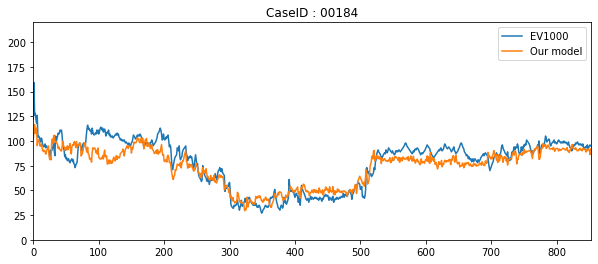

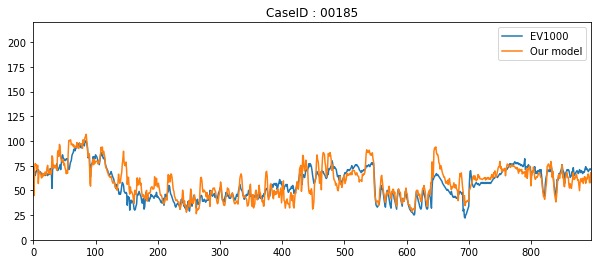

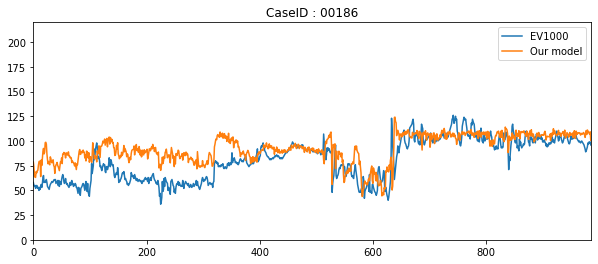

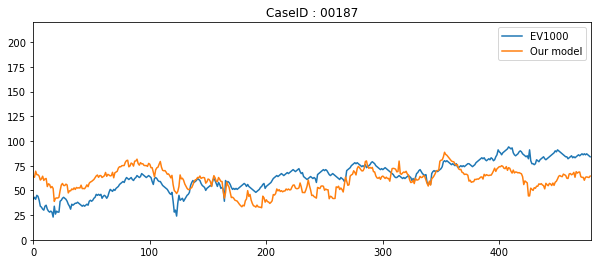

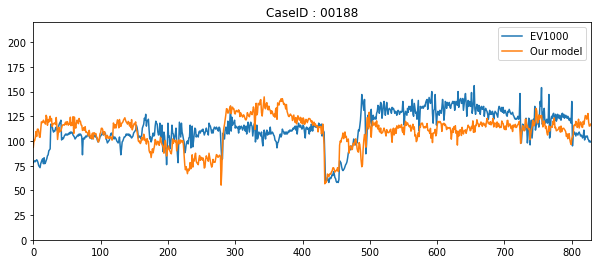

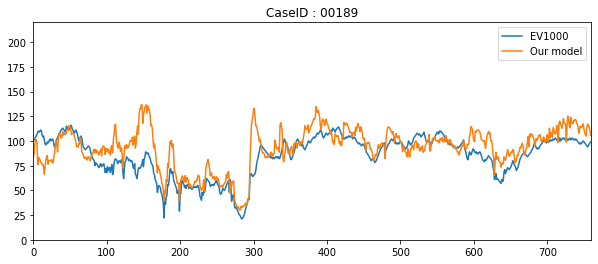

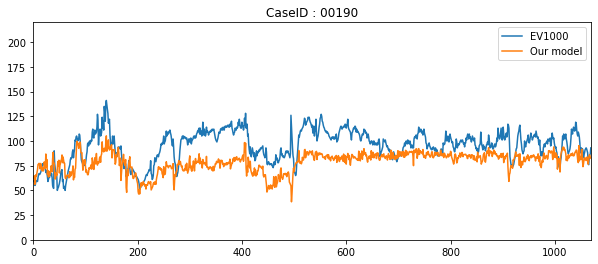

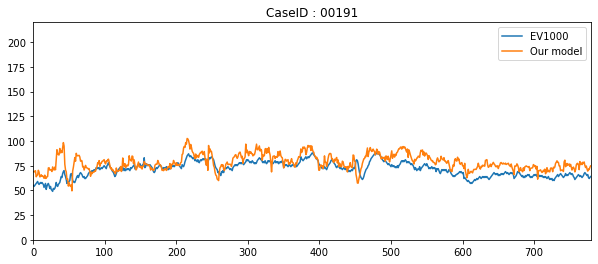

In [ ]:
for chart in np.unique(charts_test):
    case_output = simple_cnn_result[charts_test == chart]
    case_target = ylabel_test[charts_test == chart]
    plt.figure(figsize=(10, 4))
    plt.xlim([0, len(case_output)])
    plt.ylim([0, 220])
    plt.plot(np.arange(0, len(case_target)), case_target,
             label='EV1000')
    plt.plot(np.arange(0, len(case_output)), case_output,
             label='Our model')
    plt.legend(loc='upper right')
    # plt.text(0.5, 145, loa_textstr, fontsize=10)
    plt.title('CaseID : {}'.format(chart))
    plt.show()

## Transfer learning
딥러닝 모델은 초기화 방법에 따라 모델의 성능이 크게 달라질 수 있습니다.<br>
앞선 시간의 low blood pressure 모델을 불러와 transfer learning 을 수행해 보고 결과를 비교합니다.

In [ ]:
lowbp_model = keras.models.load_model(os.path.join("/content/gdrive/My Drive/", "new_cnn_weight_balanced.h5")) # for colab
# lowbp_model = keras.models.load_model(os.path.join(download_directory, "new_cnn_weight_balanced.h5")) # for local


In [ ]:
lowbp_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1996, 32)     192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1996, 32)     5152        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1996, 32)     5152        ['conv1d_1[0][0]']               
                                                                                           

불러온 lowbp 모델에서, MLP 파트는 제외하고 convolution part만 따로 떼어내서 `base_model`로 정의합니다.

In [ ]:
base_model = Model(lowbp_model.input, lowbp_model.layers[-4].output)

In [ ]:
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1996, 32)     192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1996, 32)     5152        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1996, 32)     5152        ['conv1d_1[0][0]']               
                                                                                            

transfer learning 모델을 정의합니다.<br>
`base_model`의 모델 구조와 파라미터를 그대로 가져와서 MLP layer에 해당되는 부분만 추가하고 학습을 진행합니다.


In [ ]:
inp_transfer = Input(shape=(aline_train.shape[1], 1))

x = base_model(inp_transfer, training=False) #false하면 학습 안하고, True면 다시 학습 
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
out_transfer = Dense(1)(x)

In [ ]:
transfer_model = Model(inputs=[inp_transfer], outputs=[out_transfer])
adam_optimizer = tf.keras.optimizers.Adam(lr=0.001)
transfer_model.compile(loss='mse', optimizer=adam_optimizer, metrics=['mae', 'mse'])

In [ ]:
transfer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000, 1)]         0         
                                                                 
 model_1 (Functional)        (None, 384)               72320     
                                                                 
 dense_3 (Dense)             (None, 128)               49280     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cache_path_transfer = os.path.join("/content/gdrive/My Drive/", "simple_cnn_weight_sv_transfer.h5")
# cache_path_transfer = os.path.join(download_directory, "simple_cnn_weight_sv_transfer.h5")
callback_functions_transfer = [ModelCheckpoint(monitor='val_loss', filepath=cache_path_transfer, verbose=1, save_best_only=True),
                      EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
                      ]

In [ ]:
transfer_model_train_history = transfer_model.fit(aline_train, ylabel_train, epochs = 10, 
                                                batch_size=batch_size, verbose=1, validation_split=0.2,
                                               callbacks=callback_functions_transfer)

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 1168.8125 - mae: 25.8880 - mse: 1168.8125
Epoch 1: val_loss improved from inf to 885.91376, saving model to /home/lims1/python/KOHIadvance2022/simple_cnn_weight_sv_transfer.h5
41/41 [==============================] - 9s 184ms/step - loss: 1168.8125 - mae: 25.8880 - mse: 1168.8125 - val_loss: 885.9138 - val_mae: 24.7400 - val_mse: 885.9138
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 595.1172 - mae: 19.5367 - mse: 595.1172
Epoch 2: val_loss improved from 885.91376 to 840.48828, saving model to /home/lims1/python/KOHIadvance2022/simple_cnn_weight_sv_transfer.h5
41/41 [==============================] - 7s 166ms/step - loss: 595.1172 - mae: 19.5367 - mse: 595.1172 - val_loss: 840.4883 - val_mae: 24.0913 - val_mse: 840.4883
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 504.2478 - mae: 17.8827 - mse: 504.2478
Epoch 3: val_loss improved from 840.48828 to 428.68295, saving model to 

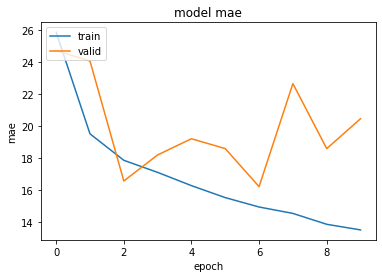

In [ ]:
plt.plot(transfer_model_train_history.history['mae'])
plt.plot(transfer_model_train_history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

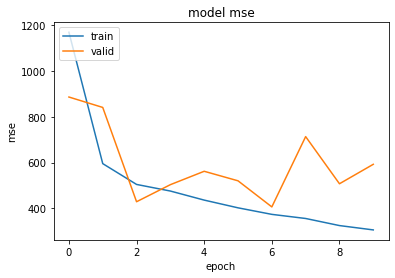

In [ ]:
plt.plot(transfer_model_train_history.history['mse'])
plt.plot(transfer_model_train_history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

모델 결과 추론

In [ ]:
transfer_model.load_weights(cache_path_transfer)
transfer_model_result = transfer_model.predict(aline_test).flatten()

267/267 [==============================] - 2s 5ms/step


In [ ]:
transfer_model_result

array([59.66049 , 56.170338, 55.349678, ..., 82.42853 , 78.877846,
       84.05772 ], dtype=float32)

In [ ]:
ylabel_test

array([60., 59., 60., ..., 81., 79., 80.])

In [ ]:
def MSE(y, pred):
    return np.mean(np.square(y-pred))

def MAE(y, pred):
    return np.mean(np.abs(y-pred))

In [ ]:
print('MSE from scratch: {:.3f}'.format(MSE(ylabel_test, simple_cnn_result)))
print('MSE from transfer: {:.3f}'.format(MSE(ylabel_test, transfer_model_result)))
print('\n')
print('MAE from scratch: {:.3f}'.format(MAE(ylabel_test, simple_cnn_result)))
print('MAE from transfer: {:.3f}'.format(MAE(ylabel_test, transfer_model_result)))

MSE from scratch: 271.497
MSE from transfer: 256.099


MAE from scratch: 12.541
MAE from transfer: 12.120


### 학습된 모델 Visialization
> 주황색이 from scratch 모델의 예측값이고, 초록색이 transfer model의 예측값, 파란색의 정답 입니다.

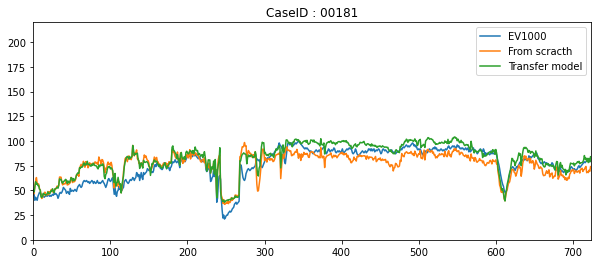

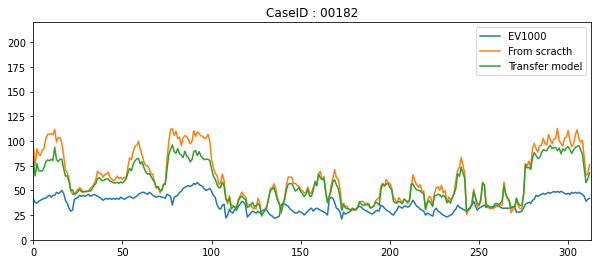

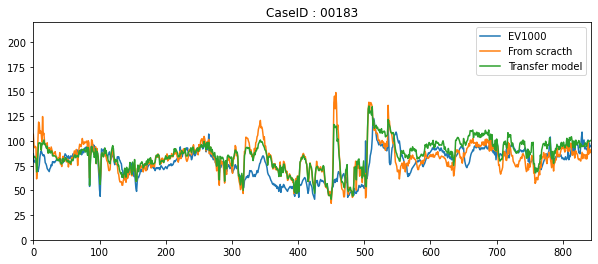

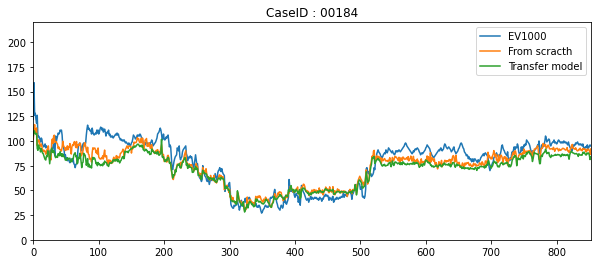

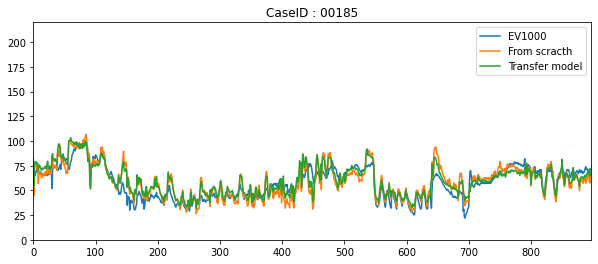

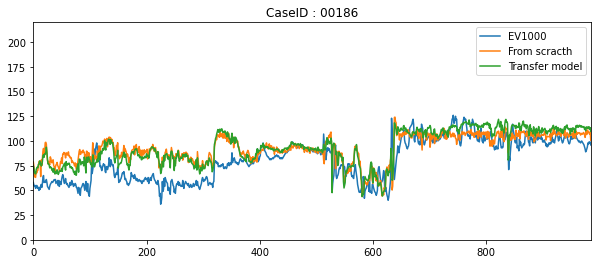

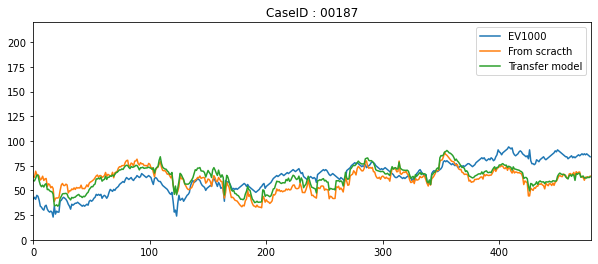

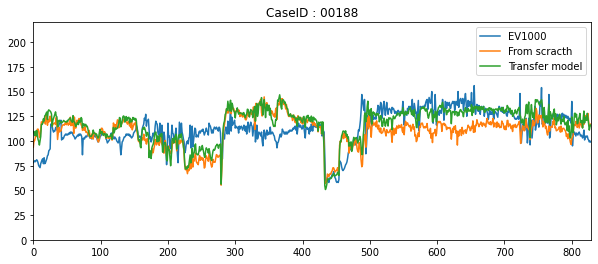

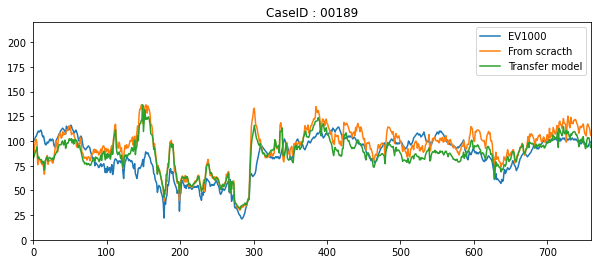

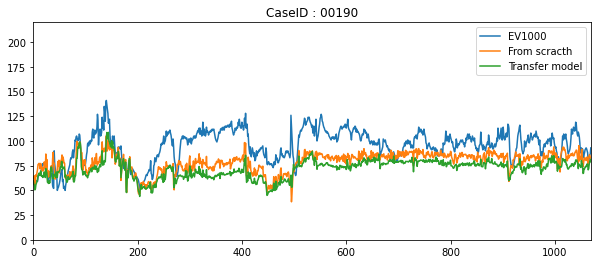

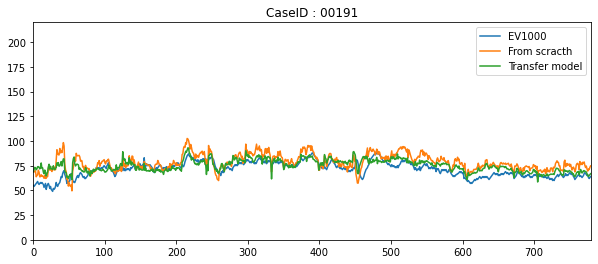

In [ ]:
for chart in np.unique(charts_test):
    case_origin = simple_cnn_result[charts_test == chart]
    case_transfer = transfer_model_result[charts_test == chart]
    case_target = ylabel_test[charts_test == chart]
    
    plt.figure(figsize=(10, 4))
    plt.xlim([0, len(case_target)])
    plt.ylim([0, 220])
    plt.plot(np.arange(0, len(case_target)), case_target,
             label='EV1000')
    plt.plot(np.arange(0, len(case_origin)), case_origin,
             label='From scracth')
    plt.plot(np.arange(0, len(case_transfer)), case_transfer,
             label='Transfer model')
    plt.legend(loc='upper right')
    # plt.text(0.5, 145, loa_textstr, fontsize=10)
    plt.title('CaseID : {}'.format(chart))
    plt.show()

## Interpretable AI model

### Gradcam

학습된 모델의 layer 이름 확인

In [ ]:
simple_cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1996, 32)     192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1996, 32)     5152        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1996, 32)     5152        ['conv1d_1[0][0]']               
                                                                                              

마지막 convolution layer를 target layer로 지정

In [ ]:
last_conv_layer_name = 'conv1d_14'

gradient heatmapping 함수 정의

In [ ]:
def make_gradcam_heatmap(signal_array, model, last_conv_layer_name):
    if len(signal_array.shape) == 1:
        signal_array = np.expand_dims(signal_array, axis=0)

    if not len(signal_array.shape) == 2:
        raise ValueError("input dimension not match")
    
    # First, we create a model that maps the input array to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the predicted value for our input array
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(signal_array)

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(preds, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0,1))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(signal_array, model, last_conv_layer_name, alpha=0.4):
    
    heatmap = make_gradcam_heatmap(signal_array, model, last_conv_layer_name)
    
    plt.figure(figsize=(20,5))
    plt.imshow(np.expand_dims(heatmap, axis=0), cmap='jet', aspect="auto", 
               interpolation='nearest',extent=[0,2000,signal_array.min(),signal_array.max()], alpha=alpha)
    plt.plot(signal_array, 'k')
    plt.colorbar()
    plt.show()

Test dataset 에서 샘플 데이터 10개 추출

In [ ]:
sampling_idx = np.random.randint(len(aline_test), size=10)
sample_aline_test = aline_test[sampling_idx, :]
sample_ylabel_test = ylabel_test[sampling_idx]

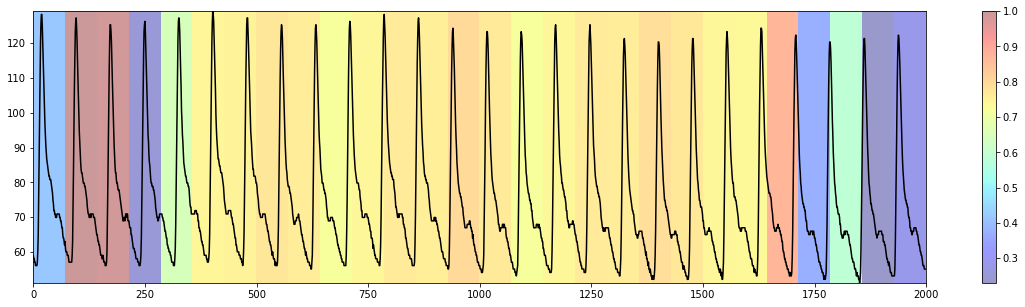

In [ ]:
display_gradcam(sample_aline_test[0], simple_cnn_model, last_conv_layer_name)

## Integreated Gradient

gradient 추출 함수 정의

In [ ]:
def get_gradients(inp_data, model, top_pred_idx = 0):
    """Computes the gradients of outputs w.r.t input array.

    Args:
        img_input: 3D signal tensor
        top_pred_idx: Predicted label for the input array

    Returns:
        Gradients of the predictions w.r.t img_input
    """

    with tf.GradientTape() as tape:
        tape.watch(inp_data)
        preds = model(inp_data)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, inp_data)
    return grads, preds

In [ ]:
def get_integrated_gradients(inp_data, model, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_data (ndarray): Original array
        model: trained deep learning model
        top_pred_idx: Predicted label for the input array
        baseline (ndarray): The baseline to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input array
    """
    # If baseline is not provided, start with a zero array
    # having same size as the input data.
    if baseline is None:
        baseline = np.zeros(inp_data.shape).astype(np.float32)
    else:
        baseline = [x.astype(np.float32) for x in baseline]

    # 1. Do interpolation.
    arr_input = inp_data.astype(np.float32)
    interpolated_arr = [
        baseline + (step / num_steps) * (arr_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_data = np.array(interpolated_arr).astype(np.float32)

    # 2. Get the gradients
    grads_arr = []
    for i, inp_data in enumerate(interpolated_data):
        inp_data = tf.expand_dims(inp_data, axis=0)
        grad_arr, pred_val = get_gradients(inp_data, model, top_pred_idx=top_pred_idx)
        grads_arr.append(grad_arr[0])

    grads_arr = tf.convert_to_tensor(grads_arr, dtype=tf.float32)

    # 3. Approximate the integral using the trapezoidal rule
    grads_arr = (grads_arr[:-1] + grads_arr[1:]) / 2.0
    avg_grads_arr = tf.reduce_mean(grads_arr, axis=0)

    # 4. Calculate integrated gradients and return
    integrated_grads_arr = (inp_data - baseline) * avg_grads_arr
    
    return integrated_grads_arr, pred_val

In [ ]:
def random_baseline_integrated_gradients(
        inp_data, model, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads_arr = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(inp_data.shape)

        igrads_arr, igrads_pred = get_integrated_gradients(
            inp_data=inp_data,
            model=model,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads_arr.append(igrads_arr)

        integrated_grads = integrated_grads_arr

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    integrated_grads = tf.reduce_mean(integrated_grads, axis=0)
    return integrated_grads, igrads_pred

In [ ]:
class GradProcessor:
    """Plot gradients of the outputs w.r.t an input array."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
            self,
            attributions,
            clip_above_percentile=99.9,
            clip_below_percentile=70.0,
            lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
                m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def process_grads(
            self,
            attributions,
            polarity="positive",
            clip_above_percentile=99.9,
            clip_below_percentile=0,
            morphological_cleanup=False,
            structure=np.ones((3, 3)),
            outlines=False,
            outlines_component_percentage=90,
            overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels -- skip this computation in 1d wave
        # attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(np.squeeze(attributions), 1) * channel
        #attributions = attributions * channel

        return attributions

    def do_process_grad(
            self,
            attributions,
            polarity="positive",
            clip_above_percentile=99.9,
            clip_below_percentile=0,
            morphological_cleanup=False,
            structure=np.ones((3, 3)),
            outlines=False,
            outlines_component_percentage=90,
            overlay=True,
            normalize=True
    ):
        positive_processed_igrad = self.process_grads(attributions,
                                                      polarity="positive",
                                                      clip_above_percentile=99.9,
                                                      clip_below_percentile=0,
                                                      morphological_cleanup=False,
                                                      structure=np.ones((3, 3)),
                                                      outlines=False,
                                                      outlines_component_percentage=90,
                                                      overlay=True)

        negative_processed_igrad = self.process_grads(attributions,
                                                      polarity="negative",
                                                      clip_above_percentile=99.9,
                                                      clip_below_percentile=0,
                                                      morphological_cleanup=False,
                                                      structure=np.ones((3, 3)),
                                                      outlines=False,
                                                      outlines_component_percentage=90,
                                                      overlay=True)

        processed_igrad = positive_processed_igrad - negative_processed_igrad

        if normalize:
            processed_igrad = np.sum(processed_igrad / 255., axis=1)
        else:
            processed_igrad = np.sum(processed_igrad, axis=1)

        return processed_igrad

In [ ]:
def build_abp_heatmap_IG(raw_wave, grad_val, thresh=0.2, alpha=0.75, sv_true=None, sv_pred=None):
    """
    raw_wave shape: (2000, 1)
    grad_val shape: (1, 2000)
    """
    f, ax = plt.subplots(figsize=(20, 7))
    
    if len(grad_val.shape)==1:
        grad_val = np.expand_dims(grad_val, axis=0)

    sns.heatmap(data=(np.abs(grad_val) > thresh) * grad_val,
                cmap='seismic', cbar=True,
                center=0., xticklabels=False, yticklabels=False, alpha=0.4
                )

    ax2 = plt.twinx()
    sns.lineplot(data=raw_wave, linewidth=2, color='g', ax=ax2, legend=False)

    if sv_true is not None:
        textstr = 'SVI TRUE: {:.3f} \nSVI PRED: {:.3f}'.format(sv_true, sv_pred)
        props = dict(boxstyle='round', facecolor='wheat', alpha=alpha)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
                verticalalignment='top', bbox=props)

    ax.axis('tight')
    ax2.set(ylim=(20, 200))

    return f

Calculate random baseline integrated gradients

In [ ]:
random_ig_result, prediction = random_baseline_integrated_gradients(sample_aline_test[0], simple_cnn_model, 0)

In [ ]:
import seaborn as sns

Visualize heatmap

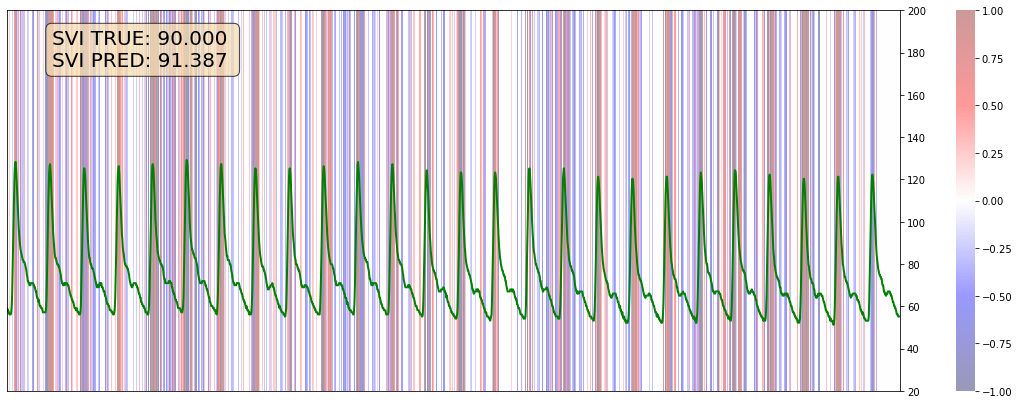

In [ ]:
grad_processor = GradProcessor()
processed_igrad = grad_processor.do_process_grad(random_ig_result)
heatmap_plot = build_abp_heatmap_IG(sample_aline_test[0], processed_igrad, sv_true=sample_ylabel_test[0], sv_pred=np.squeeze(prediction))
